In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

In [3]:
sys.path.insert(0, "../../src/main/")

In [4]:
import pandas as pd 
import numpy as np
import config, utils
import os
import sys
import data
import time
import keras
import net

Using TensorFlow backend.


In [5]:
from keras import backend as K
use_gpu = len(K.tensorflow_backend._get_available_gpus())>0
use_gpu

True

In [6]:
datafiles=net.get_datafiles()
datafiles

['/home/bo/csc2019/input/nni/traintest_submols_feat_part_0.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_1.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_2.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_3.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_4.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_5.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_6.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_7.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_8.pklz',
 '/home/bo/csc2019/input/nni/traintest_submols_feat_part_9.pklz']

In [7]:
!env|grep SLURM_CPUS_ON_NODE

In [8]:
data_std=net.get_feat_std()
data_std.shape

(3213,)

In [9]:
keras.__version__

'2.1.2'

# both

In [10]:
import importlib
importlib.reload(net)

<module 'net' from '../../src/main/net.py'>

In [11]:
model_type=2

In [12]:
%time gen = net.DataGeneratorPar(datafiles[:-1],data_size=71636, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52.7 µs


In [13]:
%time testgen = net.DataGeneratorPar([datafiles[-1]],data_size=7163, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 33.4 µs


In [14]:
model=net.make_model(model_type,hidden_units=100,bidirectional=False, use_cudnn=False)

In [15]:
optimizer = keras.optimizers.Adam()


In [16]:
model.compile(optimizer=optimizer, loss='mse', )    

In [ ]:
model.fit_generator(generator=gen, validation_data=testgen, epochs=10,use_multiprocessing=False)

# prediction

In [57]:
import importlib
importlib.reload(net)

<module 'net' from '../../src/main/net.py'>

In [58]:
model_type=1

In [59]:
model=net.make_model(model_type,hidden_units=100,bidirectional=False)

In [52]:
%time gen = net.DataGeneratorPar(datafiles[:-1],data_size=71636, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 56 µs, sys: 18 µs, total: 74 µs
Wall time: 83.4 µs


In [53]:
%time testgen = net.DataGeneratorPar([datafiles[-1]],data_size=7163, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 47 µs, sys: 15 µs, total: 62 µs
Wall time: 68.4 µs


In [60]:
model.compile(optimizer='adam', loss='mse')    

In [ ]:
model.fit_generator(generator=gen, validation_data=testgen, epochs=3,use_multiprocessing=True,
                     workers=2)

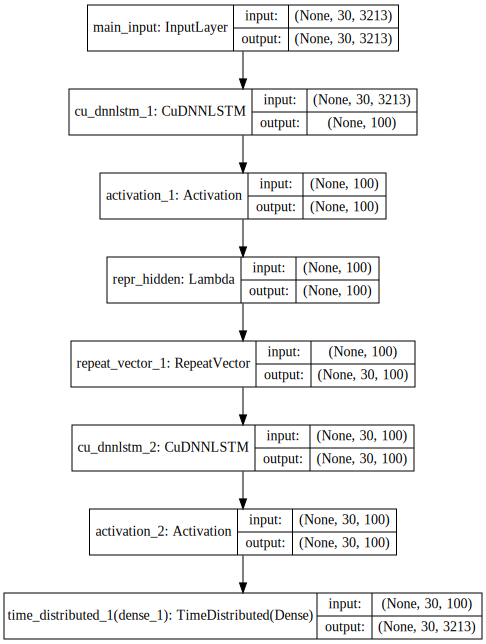

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
from keras import Model
from keras.layers import Lambda
hidden_model = Model(inputs=model.inputs, outputs=Lambda(lambda x: x[:,-1,:])(model.get_layer("repr_hidden").output))


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(hidden_model, show_shapes=True).create(prog='dot', format='svg'))

In [72]:
hidden_model.predict(gen[0][0]).shape

(64, 100)

# autoencoder

In [10]:
import importlib
importlib.reload(net)

<module 'net' from '../../src/main/net.py'>

In [11]:
model_type=0

In [12]:
%time gen = net.DataGeneratorPar(datafiles[:-1],data_size=71636, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 46.7 µs


In [13]:
%time testgen = net.DataGeneratorPar([datafiles[-1]],data_size=7163, batch_size=64, data_std=data_std, model_type=model_type)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 37.2 µs


In [14]:
ckpt = keras.callbacks.ModelCheckpoint("model_epoch_{epoch:03d}_loss_{loss:.4f}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


In [18]:
model=net.make_model(model_type,hidden_units=100,bidirectional=True, use_cudnn=False)

In [19]:
loss = lambda y_true, y_pred: 1000 * keras.losses.mse(y_true, y_pred)

In [20]:
model.compile(optimizer='adam', loss=loss)    

In [21]:
model.fit_generator(generator=gen, validation_data=testgen, epochs=10,use_multiprocessing=False,
                     workers=4, callbacks=[ckpt])

Epoch 1/10
1119/1119 [==============================] - 348s 311ms/step - loss: 4.8604 - val_loss: 3.4166
Epoch 2/10
1119/1119 [==============================] - 215s 192ms/step - loss: 3.1224 - val_loss: 2.8898
Epoch 3/10
1119/1119 [==============================] - 214s 192ms/step - loss: 3.0287 - val_loss: 2.7171
Epoch 4/10
1119/1119 [==============================] - 215s 193ms/step - loss: 2.6467 - val_loss: 2.5345
Epoch 5/10
1119/1119 [==============================] - 216s 193ms/step - loss: 2.4511 - val_loss: 2.3820
Epoch 6/10
1119/1119 [==============================] - 216s 193ms/step - loss: 2.4853 - val_loss: 2.2942
Epoch 7/10
1119/1119 [==============================] - 217s 194ms/step - loss: 2.2962 - val_loss: 2.2572
Epoch 8/10
1119/1119 [==============================] - 218s 195ms/step - loss: 2.1495 - val_loss: 2.1060
Epoch 9/10
1119/1119 [==============================] - 217s 194ms/step - loss: 2.2132 - val_loss: 2.2003
Epoch 10/10
1119/1119 [=======================

In [13]:
model.fit_generator(generator=gen, validation_data=testgen, epochs=10,use_multiprocessing=True,
                     workers=4)

Epoch 1/10
1119/1119 [==============================] - 159s 142ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 2/10
1119/1119 [==============================] - 145s 129ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 3/10
1119/1119 [==============================] - 140s 126ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/10
1119/1119 [==============================] - 145s 130ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/10
1119/1119 [==============================] - 148s 132ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/10
1119/1119 [==============================] - 140s 125ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/10
1119/1119 [==============================] - 142s 127ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10
1119/1119 [==============================] - 156s 140ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/10
1119/1119 [==============================] - 145s 129ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/10
1119/1119 [=======================